# Loading libraries

In [1]:
# GPU settings
import os
# os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,4'

# Computation settings
import jax
from jax import lax, random, config, numpy as jnp
# config.update('jax_enable_x64', True)   # for double precision, but cannot run convolution!


# import porespy as ps
import numpy as np

# Plotting settings
import matplotlib
# from google.colab import output
# output.enable_custom_widget_manager()
# %matplotlib ipympl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from matplotlib import cm

# ETC
import telegram
import pickle
import math
import datetime
from functools import partial
from typing import Callable, Any
from pprint import pprint

from tqdm import tqdm
from datetime import datetime
from pytz import timezone
from collections import deque

record_t = datetime.now(timezone('Asia/Seoul')).strftime('%Y%m%d_%H%M')[2:]
TOKEN = '6740952693:AAFOUwNFVu2O3Bpf7nlKwIlDzyNaarN7Fl8'
CHAT_ID = '5110804803'
msg = f"Lossmap was generated!\nPlease check and zoom it!"

bot = telegram.Bot(TOKEN)
def send_alram(msg=msg):
    return bot.sendMessage(chat_id=CHAT_ID, text=msg)

# Hyperparams

In [2]:
# Model
width = 300
hidden_depth = 1
target_dim = 10
num_epochs = 30
nonlinearity = 'relu'

# Datset
batch_size = 100
# minibatch_size = None
default_outer_batch_size = 2048

# Plotting
# phase_space = 'paraminit_vs_lr'
mnmx = [-6, 6, -6, 6]
default_resolution = 16
dpi = 100
figsize = (16, 8)
interactive_gui = True

if interactive_gui:
    ## interactive plotting
    # from google.colab import output
    # output.enable_custom_widget_manager()
    %matplotlib ipympl
else:
    matplotlib.use('Agg')

In [3]:
def canonical_name(i=None, record_t=record_t):
    """
    turn hyperparameters in the previous cell into a canonical base filename to
    use for this experimental condition
    """
    return f'Shallownet_zoom_{i if i is not None else ""}_W-(784x{width}, {width}x{target_dim})_activation-{nonlinearity}_epochs-{num_epochs}_batchsize-{batch_size}_resolution-{default_resolution}_time-{record_t}'

In [4]:
# Make the save directory
from datetime import datetime
from pytz import timezone
record_t = datetime.now(timezone('Asia/Seoul')).strftime('%Y%m%d_%H%M%S')[2:]
output_path = f"./output/{canonical_name(None)}"
os.makedirs(output_path + "/train", exist_ok=True)
os.makedirs(output_path + "/test", exist_ok=True)
os.makedirs(output_path + "/thetas", exist_ok=True)
os.makedirs(output_path + "/lossacc", exist_ok=True)

# Modeling

In [5]:
from model.shallownet import *

def split_and_train(theta, hparams, batches, tbatches, num_epochs, outer_batch_size=None):
    
    if outer_batch_size is None:
        outer_batch_size = default_outer_batch_size

    # Theta initialization
    if theta is None:
        theta = init(42, width, hidden_depth)

    # Cut off the learning rates as bite size
    bs = hparams.shape[0]
    if bs > outer_batch_size:
        train_loss1, test_loss1 = split_and_train(theta, hparams[:bs//2, ], batches, tbatches, num_epochs)
        train_loss2, test_loss2 = split_and_train(theta, hparams[bs//2:, ], batches, tbatches, num_epochs)
        return jnp.concatenate((train_loss1, train_loss2), axis=0), jnp.concatenate((test_loss1, test_loss2), axis=0)

    # Train session
    _theta = jax.tree_map(lambda u: jnp.tile(u, (bs,) + (1,) * len(u.shape)), theta)
    loss_archive, acc_archive, tloss_archive, tacc_archive = train(_theta, hparams, batches, tbatches, num_epochs)
    return convergence_measure(jnp.stack(loss_archive, axis=-1)), convergence_measure(jnp.stack(tloss_archive, axis=-1))    # stack-->(16, 100), convergence_measure-->(...?)


# Trainining session
def train(_theta, hparams, batches, tbatches, num_epochs):
    global tile_batch

    # Training session
    theta_archive = []
    loss_archive = []
    acc_archive = []
    tile_batch += 1

    desc = f'[Tile {tile_batch}/{math.ceil(default_resolution**2/default_outer_batch_size)}] Epochs: '
    for _ in tqdm(range(num_epochs), total=num_epochs, desc=desc, leave=False):
        # Need to divide X and Y as each batch.
        loss_epoch = 0. # broadcasting --> (16,)
        acc_epoch = 0.
        for batch in batches.as_numpy_iterator():
            _theta, _loss, _acc = train_step(_theta, hparams, batch)
            loss_epoch += _loss
            acc_epoch += _acc
        loss_epoch /= total_batch   # (16,)
        acc_epoch /= total_batch
        theta_archive.append(_theta)        # [(16, 784, 300), (16,), (16,), (16, 300, 10)] * 100
        loss_archive.append(loss_epoch)     # [(16,)] * 100
        acc_archive.append(acc_epoch.astype(float))

    # Epoch-validating session
    tloss_archive = []
    tacc_archive = []
    tloss = 0.
    tacc = 0.
    for tbatch in tbatches.as_numpy_iterator():
        _, _tloss, _tacc = eval_step(_theta, tbatch)
        tloss += _tloss
        tacc += _tacc
    tloss /= total_tbatch
    tacc /= total_tbatch
    tloss_archive.append(tloss)
    tacc_archive.append(tacc)
    return loss_archive, acc_archive, tloss_archive, tacc_archive

# Compensator
# @jax.jit
@partial(jax.vmap, in_axes=(0,), out_axes=0)
def convergence_measure(v, max_val=1e6):
    fin = jnp.isfinite(v)
    v = v * fin + max_val * (1-fin)
    v /= v[0]
    exceeds = (v > max_val)
    v = v * (1-exceeds) + max_val * exceeds
    converged = (jnp.mean(v[-20:]) < 1)
    return jnp.where(converged, -jnp.sum(v), jnp.sum(1/v)) / v.shape[0]  # All-epochs summation loss
    



# Plotting and Measure the Fractal Dimension

In [6]:
# Generate the lossmap
def gen_img(mnmx, resolution=None, savedir=None):
    """
    generate an image of the hyperparameter landscape,
    for a range of hyperparameter values specified by mnmx
    """

    if resolution is None:
        resolution = default_resolution

    mn1, mx1, mn2, mx2 = mnmx
    gg1 = jnp.logspace(mn1, mx1, resolution)
    gg2 = jnp.logspace(mn2, mx2, resolution)
    lr0, lr1 = jnp.meshgrid(gg2, gg1)
    lr = jnp.stack([lr0.ravel(), lr1.ravel()], axis=-1)

    V, tV = split_and_train(
        theta=None,
        hparams=lr,
        batches=train_ds,
        tbatches=test_ds,
        num_epochs=num_epochs
        )

    V = V.reshape((resolution, resolution))
    tV = tV.reshape((resolution, resolution))


    send_alram(msg=msg)
    if savedir:
        jnp.save(f"{savedir}/train/{canonical_name(record_t=datetime.now(timezone('Asia/Seoul')).strftime('%Y%m%d_%H%M')[2:])}.npy", V)
        jnp.save(f"{savedir}/test/{canonical_name(record_t=datetime.now(timezone('Asia/Seoul')).strftime('%Y%m%d_%H%M')[2:])}.npy", tV)


    return V, tV


# Measure the fractal dim
def extract_edges(X):
    """
    define edges as sign changes in the scalar representing convergence or
    divergence rate -- on one side of the edge training converges,
    while on the other side of the edge training diverges
    """

    Y = jnp.stack((X[1:,1:], X[:-1,1:], X[1:,:-1], X[:-1,:-1]), axis=-1)
    Z = jnp.sign(jnp.max(Y, axis=-1)*jnp.min(Y, axis=-1))
    return Z<0

def estimate_fractal_dimension(hist_video, show_plot=True, saveas=None):
    edges = [extract_edges(U[0]) for U in hist_video]
    box_counts = [ps.metrics.boxcount(U) for U in edges]
    all_images = np.concatenate([bc.slope for bc in box_counts])

    if show_plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        ax1.set_yscale('log')
        ax1.set_xscale('log')
        ax1.set_xlabel('box edge length')
        ax1.set_ylabel('number of boxes spanning phases')
        ax2.set_xlabel('box edge length')
        ax2.set_ylabel('image')
        ax2.set_xscale('log')

        for bc in box_counts:
            ax1.plot(bc.size, bc.count,'-o')
            ax2.plot(bc.size, bc.slope,'-o')

    if saveas:
        plt.savefig(saveas)

    mfd = np.median(all_images)
    print(f'median fractal dimension estimate {mfd}')

    return mfd


# Interploating
def cdf_img(x, x_ref, buffer=0.25):
    """
    rescale x, relative to x_ref (x_ref is often the same as x), to achieve a uniform
    distribution over values with positive and negative intensities, but also to
    preserve the sign of x. This makes for a visualization that shows more
    structure.
    """
    u = jnp.sort(x_ref.ravel())
    num_neg = jnp.sum(u<0)
    num_nonneg = u.shape[0] - num_neg
    v = jnp.concatenate((jnp.linspace(-1,-buffer,num_neg), jnp.linspace(buffer,1,num_nonneg)), axis=0)
    y = jnp.interp(x, u, v)
    return -y


# Notation
def truncate_sci_notation(numbers):
    """
    keeping enough significant digits that the
    numbers disagree in four digits
    """

    # Convert numbers to scientific notation
    n1_sci, n2_sci = "{:.15e}".format(numbers[0]), "{:.15e}".format(numbers[1])

    # Extract the significant parts and exponents
    sig_n1, exp_n1 = n1_sci.split('e')
    sig_n2, exp_n2 = n2_sci.split('e')

    # Find the first position at which they disagree
    min_len = min(len(sig_n1), len(sig_n2))
    truncate_index = min_len

    for i in range(min_len):
        if (sig_n1[i] != sig_n2[i]) or (exp_n1 != exp_n2):
            # +4 accounts for 4 digits after the first disagreement
            truncate_index = i + 4
            if i == 0:
                truncate_index += 1 # Account for decimal point
        break

    exp_n1 = exp_n1[0] + exp_n1[2]
    exp_n2 = exp_n2[0] + exp_n2[2]
    if (exp_n1 == "+00") and (exp_n2 == "+00"):
        # don't bother with scientific notation if exponent is 0
        return [sig_n1[:truncate_index], sig_n2[:truncate_index]]

    # Truncate and reconstruct the scientific notation
    truncated_n1 = "{}e{}".format(sig_n1[:truncate_index], exp_n1)
    truncated_n2 = "{}e{}".format(sig_n2[:truncate_index], exp_n2)

    return [truncated_n1, truncated_n2]

def tickslabels(mnmx):
    return mnmx, truncate_sci_notation(10.**np.array(mnmx))

In [7]:
# Animating zoom sequences and interpolating between frames
def zoom_out_sequence(hist_final, growth_factor=2., max_scale=6):
  """
  generate a sequence of (image, bounds) zooming out from the (image, bounds) in hist_final
  """

  image, mnmx = hist_final

  cT = np.array([(mnmx[0] + mnmx[1])/2., (mnmx[2] + mnmx[3])/2.])
  wT = np.array([mnmx[1] - mnmx[0], mnmx[3] - mnmx[2]])

  hist = [(image, mnmx)]
  w_scale = 1.
  while np.min(wT * w_scale) < max_scale:
    w_scale *= 2
    mnmx = [
        cT[0] - w_scale * wT[0]/2.,
        cT[0] + w_scale * wT[0]/2.,
        cT[1] - w_scale * wT[1]/2.,
        cT[1] + w_scale * wT[1]/2.,
    ]
    hist.insert(0, (np.zeros((2,2)), mnmx))

  return hist

def increase_resolution(history, target_res):
  """
  Increase the resolution of images of a fractal landscape that we've already
  generated.

  Find the first entry in history with resolution below target_res, and increase
  its resolution. If all images are already at least the target resolution,
  return False.
  """

  new_h = []
  for ii in range(len(history)):
    h = history[ii]
    image, mnmx = h
    if image.shape[0] < target_res:
      current_time = datetime.datetime.now()
      print( f"increasing resolution of {ii} / {len(history)} at {current_time}, current resolution is {image.shape}")
      image = gen_img(mnmx, resolution=target_res)
      history[ii] = (image, mnmx)
      return True
  return False

def interpolate_history(hist1, hist2, alpha):
  """
  get the mnmx (hyperparameter bounding box) value for a fraction alpha between
  two images
  """

  _, mnmx1 = hist1
  _, mnmx2 = hist2

  if alpha == 0:
    # avoid NaNs on very last frame
    return mnmx1

  w1 = np.array([mnmx1[1] - mnmx1[0], mnmx1[3] - mnmx1[2]])
  w2 = np.array([mnmx2[1] - mnmx2[0], mnmx2[3] - mnmx2[2]])
  c1 = np.array([(mnmx1[0] + mnmx1[1])/2, (mnmx1[2] + mnmx1[3])/2])
  c2 = np.array([(mnmx2[0] + mnmx2[1])/2, (mnmx2[2] + mnmx2[3])/2])

  gamma = np.exp((1-alpha)*0 + alpha*np.log(w2/w1))

  # ct = cstar + (c1 - cstar)*gamma
  # c1 = cstar + (c1 - cstar)*1
  # c2 = cstar + (c1 - cstar)*w2/w1
  cstar = (c2 - c1*w2/w1) / (1 - w2 / w1)

  ct = cstar + (c1 - cstar)*gamma
  hwt = gamma*w1

  return [ct[0] - hwt[0]/2, ct[0] + hwt[0]/2, ct[1] - hwt[1]/2, ct[1] + hwt[1]/2]


def em(extent_rev):
  return [extent_rev[2], extent_rev[3], extent_rev[0], extent_rev[1]]

def make_animator(history, timesteps_per_transition=60, reference_scale=None, cmap='Spectral'):

  fig, ax, im1 = show_img(history[0][0], history[0][1], newmnmx=None,
                          handler=False, reference_scale=reference_scale, cmap=cmap)

  im2 = ax.imshow(
      jnp.zeros_like(history[1][0]), extent=em(history[1][1]), origin='lower',
      vmin = -1, vmax = 1,
      cmap=cmap,
      aspect='auto',
      interpolation='nearest'
      )

  im3 = ax.imshow(
      jnp.zeros_like(history[1][0]), extent=em(history[1][1]), origin='lower',
      vmin = -1, vmax = 1,
      cmap=cmap,
      aspect='auto',
      interpolation='nearest'
      )

  def animate(n):
    hist_index = n // timesteps_per_transition
    alpha = (n % timesteps_per_transition) / timesteps_per_transition

    hist1 = history[hist_index]
    if hist_index >= len(history)-1:
      hist2 = hist1 # very last frame
    else:
      hist2 = history[hist_index+1]
    if hist_index >= len(history)-2:
      hist3 = hist2 # very last frame
    else:
      hist3 = history[hist_index+2]

    lims = interpolate_history(hist1, hist2, alpha)

    # interpolation scheme for image restretch / colormap
    alpha_area = jnp.sin(alpha*np.pi/2)**2

    print(f'frame {n} / {timesteps_per_transition*len(history)}, zoom step {hist_index} / {len(history)}', end='\r', flush=True)

    img_1 = (1-alpha_area)*cdf_img(hist1[0], hist1[0]) + alpha_area*cdf_img(hist1[0], hist2[0])
    img_2 = (1-alpha_area)*cdf_img(hist2[0], hist1[0]) + alpha_area*cdf_img(hist2[0], hist2[0])
    img_3 = (1-alpha_area)*cdf_img(hist3[0], hist1[0]) + alpha_area*cdf_img(hist3[0], hist2[0])

    im1.set_data(img_1)
    im1.set_extent(em(hist1[1]))
    im2.set_data(img_2)
    im2.set_extent(em(hist2[1]))
    im3.set_data(img_3)
    im3.set_extent(em(hist3[1]))
    im3.set_alpha(alpha)

    ax.set_ylim(lims[0], lims[1])
    ax.set_xlim(lims[2], lims[3])

    # Set the new tick positions
    ax.set_xticks(*tickslabels([lims[2], lims[3]]))
    ax.set_yticks(*tickslabels([lims[0], lims[1]]), rotation=90)

    labels = ax.get_xticklabels()
    labels[0].set_horizontalalignment('left')
    labels[1].set_horizontalalignment('right')
    labels = ax.get_yticklabels()
    labels[0].set_verticalalignment('bottom')
    labels[1].set_verticalalignment('top')

    return fig,

  anim = animation.FuncAnimation(fig,animate,frames=timesteps_per_transition*(len(history)-1)+1, repeat=False)
  return anim

In [8]:
# Interactive plotting
cids = []
click_event = [None]

def onclick(event):
    click_event[0] = (event.xdata, event.ydata)

def onrelease(event, fig, im, rect, mnmx, img, recalculate_image=True):
    global tile_batch, zoom_seq
    tile_batch = 0
    zoom_seq += 1
    
    if click_event[0] is None:
        return

    e0 = [click_event[0][0], event.xdata]
    e1 = [click_event[0][1], event.ydata]

    for v in e0+e1:
        if v is None:
            return

    newmnmx = [np.min(e1), np.max(e1), np.min(e0), np.max(e0)]

    min_w = (mnmx[1] - mnmx[0])/20
    if newmnmx[1] - newmnmx[0] < min_w:
        c = (newmnmx[1] + newmnmx[0])/2.
        newmnmx[0] = c - min_w/2
        newmnmx[1] = c + min_w/2
    min_w = (mnmx[3] - mnmx[2])/20

    if newmnmx[1] - newmnmx[0] < min_w:
        c = (newmnmx[3] + newmnmx[2])/2.
        newmnmx[2] = c - min_w/2
        newmnmx[3] = c + min_w/2

    for v in newmnmx:
        if v is None:
            return

    plot_img(img, mnmx, newmnmx, fig=fig, im=im, rect=rect)
    plt.draw()

    if recalculate_image:
        click_event[0] = None
        mnmx = newmnmx
        img = gen_img(mnmx)
        plot_img(img, mnmx, None, fig=fig, im=im, rect=rect)


def plot_img(image, mnmx, newmnmx=None, fig=None, im=None, rect=None,
             handler=True, savename=None,
             reference_scale=None,
             cmap='Spectral',
             title=""
             ):

    mn1, mx1, mn2, mx2 = mnmx
    trainimg, testimg = image

    if reference_scale is None:
        reference_scale_train = trainimg
        reference_scale_test = testimg


    trainimg = cdf_img(trainimg, reference_scale_train)
    testimg = cdf_img(testimg, reference_scale_test)

    # ax1 = None
    if im is not None:
        im1, im2 = im

    if fig is None:
        fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi, sharey=True, constrained_layout=True)
        ax = ax.flatten()
        im1 = ax[0].imshow(trainimg,
                        extent=[mn2, mx2, mn1, mx1],
                        origin='lower',
                        vmin=-1, vmax=1,
                        cmap=cmap,
                        aspect='auto',
                        interpolation='nearest'
                        )
        im2 = ax[1].imshow(testimg,
                        extent=[mn2, mx2, mn1, mx1],
                        origin='lower',
                        vmin=-1, vmax=1,
                        cmap=cmap,
                        aspect='auto',
                        interpolation='nearest'
                        )
        # fig.colorbar(im1, ax=ax.ravel().tolist())
        batch_text = f"{num_epochs} epochs, {batch_size} batches"
        title = f'Trainability dependence on parameter initialization and learning rate\nW[(784,{width}), ({width},10)], {nonlinearity}, {batch_text}'
        if not title == "":
        #   plt.title(title)
            fig.suptitle(title)

        fig.supxlabel('Input layer weight offset')
        fig.supylabel('Learning rate')

        rect = patches.Rectangle((mn2, mn1), mx2-mn2, mx1-mn1, linewidth=1, edgecolor='r', facecolor='none')
        ax[0].add_patch(rect)
        rect = patches.Rectangle((mn2, mn1), mx2-mn2, mx1-mn1, linewidth=1, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)

    im1.set_extent([mn2, mx2, mn1, mx1])
    im1.set_data(trainimg)
    im2.set_extent([mn2, mx2, mn1, mx1])
    im2.set_data(testimg)

    # Set the new tick positions on the x-axis
    # aaxx = plt.gca()
    ax = fig.axes
    ax[0].set_title("Training Lossmap")
    ax[1].set_title("Evaluating Lossmap")

    for nn, aaxx in enumerate(ax):
        aaxx.set_xticks(*tickslabels([mn2, mx2]))
        aaxx.set_yticks(*tickslabels([mn1, mx1]), rotation=90)

        labels = aaxx.get_xticklabels()
        labels[0].set_horizontalalignment('left')
        labels[1].set_horizontalalignment('right')
        if nn == 0:
            labels = aaxx.get_yticklabels()
            labels[0].set_verticalalignment('bottom')
            labels[1].set_verticalalignment('top')

    if handler and (newmnmx is None):
        trainimg_history.append((trainimg, mnmx))
        testimg_history.append((testimg, mnmx))


    if newmnmx:
        mn1, mx1, mn2, mx2 = newmnmx
    rect.set_xy((mn2, mn1))
    rect.set_width(mx2-mn2)
    rect.set_height(mx1-mn1)

    if handler:
        while len(cids) > 0:
            fig.canvas.mpl_disconnect(cids.pop())

    def onrelease_partial(event):
        return onrelease(event, fig, im, rect, mnmx, img)
    def onmotion_partial(event):
        return onrelease(event, fig, im, rect, mnmx, img, recalculate_image=False)

    cids.append(fig.canvas.mpl_connect('button_press_event', onclick))
    cids.append(fig.canvas.mpl_connect('button_release_event', onrelease_partial))
    # cids.append(fig.canvas.mpl_connect('motion_notify_event', onmotion_partial))

    # plt.tight_layout()

    im = (im1, im2)
    plt.draw()

    if savename:
        plt.savefig(savename)

    return fig, ax, im


def increase_resolution(train_history, test_history, target_res):
  """
  Increase the resolution of images of a fractal landscape that we've already
  generated.

  Find the first entry in history with resolution below target_res, and increase
  its resolution. If all images are already at least the target resolution,
  return False.
  """

  new_h = []
  for ii in range(len(train_history)):
    train_h = train_history[ii]
    test_h = test_history[ii]

    train_image, train_mnmx = train_h
    test_image, test_mnmx = test_h

    if train_image.shape[0] < target_res:
      current_time = datetime.now()
      print( f"increasing resolution of {ii} / {len(train_history)} at {current_time}, current resolution is {train_image.shape}")
      train_image, test_image = gen_img(train_mnmx, resolution=target_res)
      train_history[ii] = (train_image, train_mnmx)
      test_history[ii] = (test_image, test_mnmx)

      return True
  return False


In [9]:
def show_img(image, mnmx, newmnmx=None, fig=None, im=None, rect=None,
             handler=True, savename=None,
             reference_scale=None,
             cmap='Spectral',
             title=""
             ):
  mn1, mx1, mn2, mx2 = mnmx

  if reference_scale is None:
    reference_scale = image

  image = cdf_img(image, reference_scale)

  ax1 = None
  if fig is None:
    fig, (ax1) = plt.subplots(figsize=(figsize[0]/2, figsize[1]), dpi=dpi)
    im = ax1.imshow(image,
                    extent=[mn2, mx2, mn1, mx1],
                    origin='lower',
                    vmin=-1, vmax=1,
                    cmap=cmap,
                    aspect='auto',
                    interpolation='nearest'
                    )
    fig.colorbar(im, ax=ax1)
    batch_text = f"{num_epochs} epochs, {batch_size} batches"
    title = f'Trainability dependence on parameter initialization and learning rate\nW[({width},{width}), ({width},10)], {nonlinearity}, {batch_text}'

    if not title == "":
      plt.title(title)

    ax1.set_ylabel('Learning rate')
    ax1.set_xlabel('Input layer weight offset')

    rect = patches.Rectangle((mn2, mn1), mx2-mn2, mx1-mn1, linewidth=1, edgecolor='r', facecolor='none')
    ax1.add_patch(rect)

  im.set_extent([mn2, mx2, mn1, mx1])
  im.set_data(image)

  # Set the new tick positions on the x-axis
  aaxx = plt.gca()
  aaxx.set_xticks(*tickslabels([mn2, mx2]))
  aaxx.set_yticks(*tickslabels([mn1, mx1]), rotation=90)

  labels = aaxx.get_xticklabels()
  labels[0].set_horizontalalignment('left')
  labels[1].set_horizontalalignment('right')
  labels = aaxx.get_yticklabels()
  labels[0].set_verticalalignment('bottom')
  labels[1].set_verticalalignment('top')

  if handler and (newmnmx is None):
    image_history.append((image, mnmx))

  if newmnmx:
    mn1, mx1, mn2, mx2 = newmnmx
  rect.set_xy((mn2, mn1))
  rect.set_width(mx2-mn2)
  rect.set_height(mx1-mn1)

  if handler:
    while len(cids) > 0:
      fig.canvas.mpl_disconnect(cids.pop())

    def onrelease_partial(event):
      return onrelease(event, fig, im, rect, mnmx, img)
    def onmotion_partial(event):
      return onrelease(event, fig, im, rect, mnmx, img, recalculate_image=False)

    cids.append(fig.canvas.mpl_connect('button_press_event', onclick))
    cids.append(fig.canvas.mpl_connect('button_release_event', onrelease_partial))
    # cids.append(fig.canvas.mpl_connect('motion_notify_event', onmotion_partial))

  plt.tight_layout()

  plt.draw()

  if savename:
    plt.savefig(savename)

  return fig, ax1, im

# Generating the lossmap

In [10]:
from datasets.mnist import *

train_ds = data_normalize(train_ds).shuffle(buffer_size=10, seed=42).batch(batch_size).prefetch(1).take(1000)
test_ds = data_normalize(test_ds).shuffle(buffer_size=10, seed=42).batch(batch_size).prefetch(1).take(1000)

total_batch = train_ds.cardinality().numpy()
total_tbatch = test_ds.cardinality().numpy()

2024-04-24 09:08:26.105063: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-24 09:08:26.998660: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


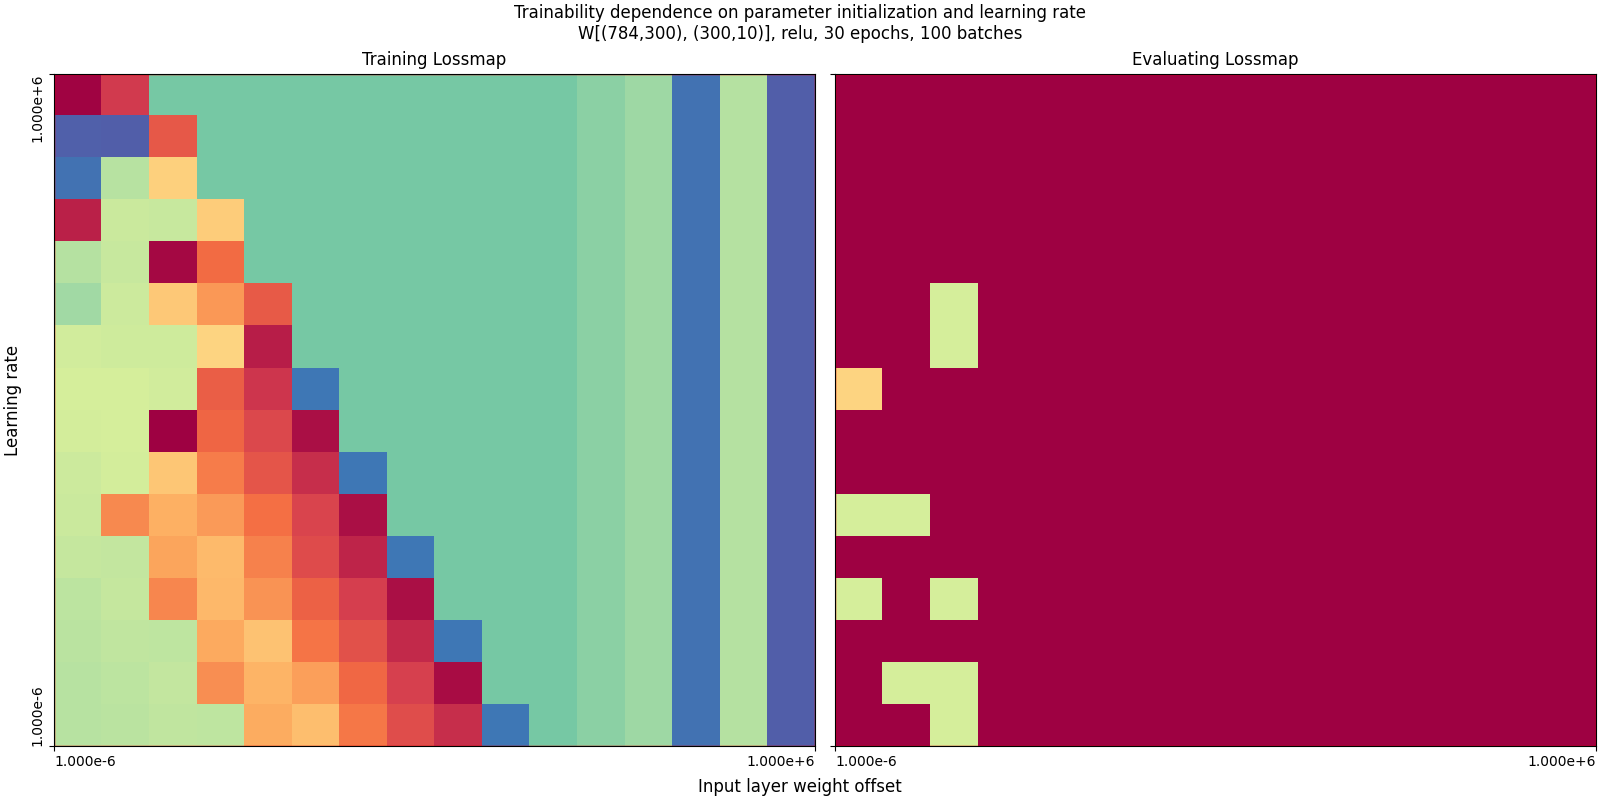

In [11]:
# Get the lossmap
output_path = f"./output/{canonical_name()}"
tile_batch = 0
zoom_seq = 0
pca_thetas = []

send_alram(msg="Start training.")

cids = []
click_event = [None]
trainimg_history = []
testimg_history = []
img = gen_img(mnmx)

plt.close('all')
plt.ion()
plot_img(img, mnmx, None, savename=f"{output_path}/{canonical_name(record_t=datetime.now(timezone('Asia/Seoul')).strftime('%Y%m%d_%H%M')[2:])}.png")
# plot_img(img, mnmx, None, savename=f"{output_path}/1.png")

plt.show()

In [12]:
# for px in range(1024):
#     for epoch in range(100):
#         fpth = f'{output_path}/lossacc/zoom0_px{px}_ep{epoch}.pickle'
#         with open(fpth, 'rb') as f:
#             rec_lossacc = pickle.load(f)
#             # if rec_lossacc['acc'] > 0.2:
#             print(f"px{px}-Epoch{epoch}-", rec_lossacc)

for i in range(5):
    pklname = f"{output_path}/thetas/zoom0_ld{i}.pickle"
    with open(pklname, 'rb') as pkl:
        pkl = pickle.load(pkl)
        print(pkl['W'][0][0].shape)

FileNotFoundError: [Errno 2] No such file or directory: './output/Shallownet_zoom__W-(784x300, 300x10)_activation-relu_epochs-30_batchsize-100_resolution-16_time-240424_0908/thetas/zoom0_ld0.pickle'

# Show all the generated images

## Train images

In [ ]:
estimate_fractal_dimension(trainimg_history)

In [ ]:
plt.close('all')

for ii, impair in enumerate(trainimg_history):
    image, mnmx = impair
    newmnmx = None
    if ii < len(trainimg_history)-1:
        newmnmx = trainimg_history[ii+1][1]
    # fname = f'fractal_train_width{width}_depth{depth}_datasetparamratio{dataset_param_multiple}_minibatch{minibatch_size}_nonlinearity{nonlinearity}_step{ii}_coords{mnmx}.pdf'
    # fname = None
    # print(ii, mnmx)
    str_ii = f"{ii:02}"
    show_img(image, mnmx, newmnmx=newmnmx, handler=False, savename=f'{output_path}/train/{canonical_name(str_ii)}.png')
    # plt.title(mnmx)
    fractal_dim = f"{estimate_fractal_dimension(trainimg_history[:ii]):.3f}" if ii > 1 else "0.000"
    plot_mnmx = truncate_sci_notation(10. ** np.array(mnmx))
    plt.title(f"fractal dim={fractal_dim} [{plot_mnmx[0]}, {plot_mnmx[1]}]")
    plt.tight_layout()
    # files.download(fname)

## Test images

In [ ]:
estimate_fractal_dimension(testimg_history)


In [ ]:
plt.close('all')

for ii, impair in enumerate(testimg_history):
    image, mnmx = impair
    newmnmx = None
    if ii < len(testimg_history)-1:
        newmnmx = testimg_history[ii+1][1]
    # fname = f'fractal_train_width{width}_depth{depth}_datasetparamratio{dataset_param_multiple}_minibatch{minibatch_size}_nonlinearity{nonlinearity}_step{ii}_coords{mnmx}.pdf'
    # fname = None
    # print(ii, mnmx)
    str_ii = f"{ii:02}"
    show_img(image, mnmx, newmnmx=newmnmx, handler=False, savename=f'{output_path}/test/{canonical_name(str_ii)}')
    # plt.title(mnmx)
    fractal_dim = f"{estimate_fractal_dimension(testimg_history[:ii]):.3f}" if ii > 1 else "0.000"
    plot_mnmx = truncate_sci_notation(10. ** np.array(mnmx))
    plt.title(f"fractal dim={fractal_dim} [{plot_mnmx[0]}, {plot_mnmx[1]}]")
    plt.tight_layout()
    # files.download(fname)

# Generate a movie

In [ ]:
train_hist_video = zoom_out_sequence(trainimg_history[-1], growth_factor=2.)
test_hist_video = zoom_out_sequence(testimg_history[-1], growth_factor=2.)

In [ ]:
train_hist_video[0][0][0].shape

In [ ]:
# each call to increase_resolution increases the resolution of one image and
# returns True, or returns False if all images are at or exceed the target resolution
while increase_resolution(train_hist_video, test_hist_video, 8):
    with open(f'{output_path}/train/{canonical_name(None)}.pickle', 'wb') as handle:
        pickle.dump(train_hist_video, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(f'{output_path}/test/{canonical_name(None)}.pickle', 'wb') as handle:
        pickle.dump(test_hist_video, handle, protocol=pickle.HIGHEST_PROTOCOL)

ts = 30
# train animation
anim = make_animator(train_hist_video, timesteps_per_transition=ts*2)
anim.save(f'{output_path}/train/{canonical_name(None)}.mp4',fps=ts, dpi=dpi)
#test animation
anim = make_animator(test_hist_video, timesteps_per_transition=ts*2)
anim.save(f'{output_path}/test/{canonical_name(None)}.mp4',fps=ts, dpi=dpi)

# officially end
plt.close('all')
send_alram("Finally all over!")